In [35]:
%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import pandas as pd
import numpy as np
from PIL import Image
from math import floor
import matplotlib.pyplot as plt
import datetime
from UAVSequence import UAVSequence, ImageSequence
from ValidationCallback import ValidationCallback
from VAEModel import Sampling, VAE
# Clear logs from previous runs
# %rm -rf ../logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6610779027984818834
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13336070493597735831
physical_device_desc: "device: XLA_CPU device"
]


In [37]:
NUM_INPUTS = 13
NUM_OUTPUTS = 9

img_shape = (480, 640)

# Load the dataset input and output
x = np.loadtxt('../dataset/0_input.csv', delimiter=',')#, usecols=tuple(range(NUM_INPUTS))) # (num training points, 13)
y = np.loadtxt('../dataset/0_output.csv', delimiter=',', usecols=tuple(range(NUM_OUTPUTS))) # (num training points, 11)

# Shuffle x and y, but store the indices so we can still match them with the images
hash_table = np.random.permutation(len(x))

x = x[hash_table]
y = y[hash_table]

# X = np.zeros((len(inputNums), *img_shape, 1)) # (num training points, 480, 640)

# For each of the training examples there should be exactly 1 image
# for i in range(0, len(inputNums)):
#     image = Image.open('../dataset/img_' + str(i) + '.jpg') 
#     imageArr = np.asarray(image).reshape(*img_shape, 1) # Converts the image into a 2D 480*640 array

#     X[i] = imageArr / 255


# img_data = ImageDataGenerator(rescale=1/255)
# img_data.flow_from_directory('../dataset', target_size=img_shape, color_mode='grayscale')


In [38]:
max_mag = 2.0

# print(inputNums.shape);

# def mag(x, y):
#     return np.sqrt(x * x + y * y)

# for inputRow in inputNums:
#     m = mag(*inputRow[0:2]) # constrain goal positions
#     if m > max_mag:
#         inputRow[0] = inputRow[0] * max_mag / m 
#         inputRow[1] = inputRow[1] * max_mag / m 

Let's view some of our data images

In [39]:
num_show = 10

# fig = plt.figure(figsize=(480/20, 640/20), dpi=100)
# for i in range(num_show):
#     ax = fig.add_subplot(num_show, 1, i+1)
#     plt.imshow(X[i])

Next comes actually training on the data. 
PS. If you want to view the tensorboard data, run `tensorboard --logdir logs/fit` in another window.

In [40]:
# numerical_inputs = Input(shape=(NUM_INPUTS,))
# image_inputs = Input(shape=(*img_shape, 1))

latent_dim = 1000

encoder_inputs = Input(shape=(*img_shape, 1), name="encoder_input")
a = Conv2D(32, 7, strides=4, padding="same", activation="relu")(encoder_inputs)
a = Conv2D(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2D(64, 5, strides=5, padding="same", activation="relu")(a)
a = Flatten()(a)
z_mean = Dense(latent_dim, name="z_mean")(a)
z_log_var = Dense(latent_dim, name="z_log_var")(a)
z = Sampling()([z_mean, z_log_var])
# encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder = Model(encoder_inputs, z_mean, name="encoder")

# latent_inputs = Input(shape=(latent_dim,))
a = Dense(6 * 8 * 64, activation="relu")(z)
a = Reshape((6, 8, 64))(a)
a = Conv2DTranspose(64, 5, strides=5, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
a = Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(a)
decoder_outputs = Conv2DTranspose(1, 7, strides=4, padding="same", activation="relu")(a)
# decoder_outputs = UpSampling2D(size=(4,4))(a)
# decoder = Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

# Process the image data first
# x_image = Conv2D(32, (7, 7), strides=(4, 4), padding='same', activation='relu')(image_inputs)
# x_image = Conv2D(64, (5, 5), strides=(4, 4), padding="same", activation="relu")(x_image)
# x_image = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(x_image)
# x_image = Model(image_inputs, x_image)
# x_image = Flatten()(x_image.output)

# print(x_image.shape)
# print(numerical_inputs.shape)

# Combine the latent space representation with the numerical input
# combined = concatenate([x_image, numerical_inputs])
# print(combined.shape)
# x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
# x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
# outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)
def vae_loss(input_img, reconstructed_img):
#     reconstruction_loss = tf.reduce_mean(
#         tf.keras.losses.binary_crossentropy(input_img, reconstructed_img)
#     )
    reconstruction_loss = tf.keras.losses.MSE(input_img, reconstructed_img)
    reconstruction_loss *= 480 * 640
    
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss *= -0.5
    total_loss = reconstruction_loss + kl_loss
    return total_loss

vae = Model(encoder_inputs, decoder_outputs)
vae.summary()

batch is 32
batch is 32
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 120, 160, 32) 1600        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 60, 80, 32)   9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 30, 40, 64)   18496       conv2d_25[0][0]                  
____________________________________________________________________

In [41]:
# model = Model([image_inputs, numerical_inputs], outputs)

# model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = model.fit([X, inputNums], y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[tensorboard_callback])
# history = model.fit(xy, epochs=100, callbacks=[ValidationCallback(xy_validation), tensorboard_callback] )

# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = ImageSequence(x, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, False)
xy_validation = ImageSequence(x, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, True)

NUM_EPOCHS = 10
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

In [42]:
# Save the model
vae.save('../models/vae.tf')
# vae_dir = '../models/vae_model'
# tf.saved_model.save(vae, vae_dir)

encoder.save('../models/encoder.tf')
# encoder_dir = '../models/encoder_model'
# tf.saved_model.save(encoder, encoder_dir)

# Open Tensorboard (actually, run this on the command line on your Terminal)
# %tensorboard --logdir ../logs/fit

In [43]:
# Load the model
loaded_model_vae = tf.keras.models.load_model('../models/vae.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})
loaded_model_encoder = tf.keras.models.load_model('../models/encoder.tf', custom_objects={"Sampling": Sampling, "vae_loss": vae_loss})

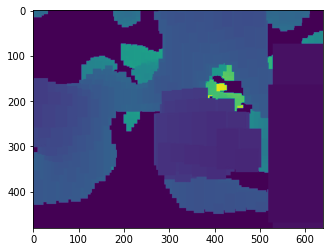

In [44]:
plt.imshow(xy[5][0][0])

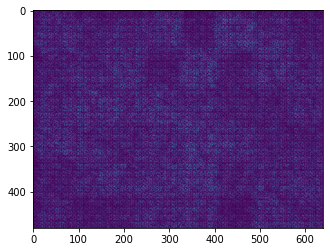

In [45]:
prediction = loaded_model_vae.predict(xy.__getitem__(7)[0])[0]
plt.imshow(prediction)

In [51]:
# # 1. Get the latent space representation of the image from the encoder
# NUM_INPUTS = 13
# NUM_OUTPUTS = 9

# VALIDATION_SPLIT = 0.2
# xy = UAVSequence(x, y, 32, img_shape, hash_table, VALIDATION_SPLIT, False)
# xy_validation = UAVSequence(x, y, 32, img_shape, hash_table, VALIDATION_SPLIT, True)


# # latent_vector = encoder.predict()
# # z_mean = encoder.get_layer("z_mean")
# encoder_input = loaded_model_encoder.get_layer("encoder_input")
# numerical_inputs = Input(shape=(NUM_INPUTS,))
# z_mean = loaded_model_encoder.get_layer("z_mean")
# z_mean = Input(shape=z_mean.shape)(z_mean)
# combined = concatenate([z_mean, numerical_inputs])
# print(combined.shape)

# z_mean = loaded_model_encoder(img, training=False)

# x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
# x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
# outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)

# model = Model([encoder_input, numerical_inputs], outputs)
# model.summary()

batch is 32
batch is 32


AttributeError: 'Dense' object has no attribute 'shape'

In [55]:
# 1. Get the latent space representation of the image from the encoder
NUM_INPUTS = 13
NUM_OUTPUTS = 9
img_shape = (480, 640)

image_inputs = Input(shape=(*img_shape, 1))
numerical_inputs = Input(shape=(NUM_INPUTS,))

z_mean = loaded_model_encoder(image_inputs, training=False)
z_mean = Flatten()(z_mean)
combined = concatenate([z_mean, numerical_inputs])
x_combined = Dense(300, kernel_regularizer=l2(0.01), activation='relu')(combined)
x_combined = Dense(60, kernel_regularizer=l2(0.01), activation='relu')(x_combined)
outputs = Dense(NUM_OUTPUTS, kernel_regularizer=l2(0.01), activation='linear')(x_combined)

model = Model([image_inputs, numerical_inputs], outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 480, 640, 1) 0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 1000)         3204808     input_17[0][0]                   
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 1000)         0           encoder[3][0]                    
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 13)]         0                                            
____________________________________________________________________________________________

In [56]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
xy = UAVSequence(x, y, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, False)
xy_validation = UAVSequence(x, y, BATCH_SIZE, img_shape, hash_table, VALIDATION_SPLIT, True)

NUM_EPOCHS = 10
model.compile(optimizer='adam', loss=tf.keras.losses.MSE)
model.fit(xy, epochs=NUM_EPOCHS, callbacks=[ValidationCallback(xy_validation)])

batch is 32
batch is 32
Epoch 1/10
 45/239 [====>.........................] - ETA: 39s - loss: 25.3369

KeyboardInterrupt: 